<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/actual_pre_training_refactor/notebooks/languageXplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install pathy -q

     |████████████████████████████████| 2.0MB 6.8MB/s 
     |████████████████████████████████| 133kB 23.8MB/s 
     |████████████████████████████████| 163kB 26.0MB/s 
     |████████████████████████████████| 102kB 9.2MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 122kB 8.0MB/s 


In [1]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=100000)
parser.add_argument('-r', '--resume', default=False, action='store_true')


# args = parser.parse_args()

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

## Sample colab config
args = parser.parse_args('''
refactor_test
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-tfr
-s GCS
-d TPU
-b 512
-la 2048
-le 512
-lp 2048
-z 256
-lr 3e-4
'''.split())

## Sample colab config
args = parser.parse_args('''
reclass2_from_working
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-s DRIVE
-d TPU
-b 512
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
'''.split())

print(args)

Namespace(actor_layer_size=2048, batch_size=512, colab=True, data_source='DRIVE', device='TPU', encoder_layer_size=512, from_tfrecords=False, gcbc=False, latent_dim=256, learning_rate=0.0003, num_distribs=None, planner_layer_size=512, qbits=None, resume=False, run_name='reclass2_from_working', test_datasets=['UR5_slow_gripper_test'], train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=100000)


In [5]:
#@title Workpace Setup (Local vs Colab)
from pathlib import Path
import os

# COLAB = False #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
# DEVICE = "CPU" #@param ["TPU", "GPU", "CPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
# TRAIN_DATASETS = ["UR5"]#,"UR5_slow_gripper","UR5_high_transition"]
# TEST_DATASET = "UR5_slow_gripper_test" #@param ["UR5_slow_gripper_test"]
GCS_USER = "sholto" #@param ["sholto", "tristan"]

if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    !git clone 'https://github.com/sholtodouglas/learning_from_play'
    WORKING_PATH = Path('/content/learning_from_play')
    drive.mount('/content/drive')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
    print(f'Storage path: {STORAGE_PATH}')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = WORKING_PATH
    print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path 'learning_from_play' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Storage path: /content/drive/My Drive/Robotic Learning


# Data Creation

In [6]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if args.device == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.122.214.82:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.122.214.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.214.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

In [7]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import lfp
from natsort import natsorted

In [9]:
# Use this to edit modules without needing to restart the kernel
!git pull
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)
importlib.reload(lfp.metric)

Already up to date.


<module 'lfp.metric' from '/content/learning_from_play/lfp/metric.py'>

### Config Flags

In [10]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)

In [11]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS)
train_dataset = dl.load(train_data)

UR5_high_transition: 100%|██████████| 32/32 [00:00<00:00, 58.17it/s]


{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


In [12]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 46.28it/s]

{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


# Model

# Training Loop

In [13]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions

import time
import io
import wandb
wandb.login()

wandb: Currently logged in as: sholto (use `wandb login --relogin` to force relogin)


True

In [14]:

# from lfp.train import LFPTrainer

In [15]:
from lfp.metric import MaxMetric, record, log, log_action_breakdown
from lfp.utils import load_weights, load_optimizer_state
import json


class LFPTrainer():

  def __init__(self, actor, encoder, planner, optimizer, strategy, args, dl):

    self.actor = actor
    self.encoder = encoder
    self.planner = planner
    self.optimizer = optimizer
    self.strategy = strategy 
    self.args = args
    self.dl = dl
    self.nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
    self.mae_action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
    self.mse_action_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    self.metrics = {}
    self.metrics['train_loss'] = tf.keras.metrics.Mean(name='train_loss')
    self.metrics['valid_loss'] = tf.keras.metrics.Mean(name='valid_loss')
    self.metrics['actor_grad_norm'] = tf.keras.metrics.Mean(name='actor_grad_norm')
    self.metrics['encoder_grad_norm'] = tf.keras.metrics.Mean(name='encoder_grad_norm')
    self.metrics['planner_grad_norm'] = tf.keras.metrics.Mean(name='planner_grad_norm')

    self.metrics['actor_grad_norm_clipped'] = tf.keras.metrics.Mean(name='actor_grad_norm_clipped')
    self.metrics['encoder_grad_norm_clipped'] = tf.keras.metrics.Mean(name='encoder_grad_norm_clipped')
    self.metrics['planner_grad_norm_clipped'] = tf.keras.metrics.Mean(name='planner_grad_norm_clipped')

    self.metrics['global_grad_norm'] = tf.keras.metrics.Mean(name='global_grad_norm')

    self.metrics['test'] = tf.keras.metrics.Mean(name='test') # Utility metrics for quick tests
    self.metrics['test2'] = tf.keras.metrics.Mean(name='test2')

    self.metrics['train_act_with_enc_loss'] = tf.keras.metrics.Mean(name='train_act_with_enc_loss')
    self.metrics['train_act_with_plan_loss'] = tf.keras.metrics.Mean(name='train_act_with_plan_loss')
    self.metrics['valid_act_with_enc_loss'] = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
    self.metrics['valid_act_with_plan_loss'] = tf.keras.metrics.Mean(name='valid_act_with_plan_loss')

    self.metrics['train_reg_loss'] = tf.keras.metrics.Mean(name='reg_loss')
    self.metrics['valid_reg_loss'] = tf.keras.metrics.Mean(name='valid_reg_loss')

    self.metrics['valid_position_loss'] = tf.keras.metrics.Mean(name='valid_position_loss')
    self.metrics['valid_max_position_loss'] = MaxMetric(name='valid_max_position_loss')
    self.metrics['valid_rotation_loss'] = tf.keras.metrics.Mean(name='valid_rotation_loss')
    self.metrics['valid_max_rotation_loss'] = MaxMetric(name='valid_max_rotation_loss')
    self.metrics['valid_gripper_loss'] = tf.keras.metrics.Mean(name='valid_rotation_loss')

  def compute_loss(self, labels, predictions, mask, seq_lens, weightings=None):
      if self.args.num_distribs is not None:
          per_example_loss = self.nll_action_loss(labels, predictions) * mask
      else:
          per_example_loss = self.mae_action_loss(labels, predictions) * mask

      per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=self.dl.batch_size )


  def compute_MAE(self, labels, predictions, mask, seq_lens, weightings=None):
      per_example_loss = self.mae_action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=self.dl.batch_size )


  def compute_regularisation_loss(self, plan, encoding):
      # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
      reg_loss = tfd.kl_divergence(encoding, plan)  # + KL(plan, encoding)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=self.dl.batch_size )


  def train_step(self, inputs, beta, prev_global_grad_norm):
      with tf.GradientTape() as actor_tape, tf.GradientTape() as encoder_tape, tf.GradientTape() as planner_tape:  # separate tapes to simplify grad_norm logging and clipping for stability
          # Todo: figure out mask and seq_lens for new dataset 
          states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], \
                                                  inputs['masks']

          if self.args.gcbc:
              distrib = self.actor([states, goals])
              loss = self.compute_loss(actions, distrib, mask, seq_lens)
              gradients = tape.gradient(loss, self.actor.trainable_variables)
              optimizer.apply_gradients(zip(gradients, self.actor.trainable_variables))
          else:
              encoding = self.encoder([states, actions])
              plan = self.planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
              z_enc = encoding.sample()
              z_plan = plan.sample()
              z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
              z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))

              enc_policy = self.actor([states, z_enc_tiled, goals])
              plan_policy = self.actor([states, z_plan_tiled, goals])

              act_enc_loss = record(self.compute_loss(actions, enc_policy, mask, seq_lens), self.metrics['train_act_with_enc_loss'])
              act_plan_loss = record(self.compute_loss(actions, plan_policy, mask, seq_lens), self.metrics['train_act_with_plan_loss'])
              reg_loss = record(self.compute_regularisation_loss(plan, encoding), self.metrics['train_reg_loss'])
              loss = act_enc_loss + reg_loss * beta

              actor_gradients = actor_tape.gradient(loss, self.actor.trainable_variables)
              encoder_gradients = encoder_tape.gradient(loss, self.encoder.trainable_variables)
              planner_gradients = planner_tape.gradient(loss, self.planner.trainable_variables)

              actor_norm = record(tf.linalg.global_norm(actor_gradients), self.metrics['actor_grad_norm'])
              encoder_norm = record(tf.linalg.global_norm(encoder_gradients), self.metrics['encoder_grad_norm'])
              planner_norm = record(tf.linalg.global_norm(planner_gradients), self.metrics['planner_grad_norm'])

              gradients = actor_gradients + encoder_gradients+planner_gradients

              # if the gradient norm is more than 3x the previous one, clip it to the previous norm for stability
              gradients = tf.cond(tf.linalg.global_norm(gradients) > 3 * prev_global_grad_norm,
                                  lambda: tf.clip_by_global_norm(gradients, prev_global_grad_norm)[0],
                                  lambda: gradients)  # must get[0] as it returns new norm as [1]

              planner_gradients = [g * 10 for g in planner_gradients]

              actor_norm_clipped = record(tf.linalg.global_norm(actor_gradients), self.metrics['actor_grad_norm_clipped'])
              encoder_norm_clipped = record(tf.linalg.global_norm(encoder_gradients), self.metrics['encoder_grad_norm_clipped'])
              planner_norm_clipped = record(tf.linalg.global_norm(planner_gradients), self.metrics['planner_grad_norm_clipped'])

              record(tf.linalg.global_norm(gradients), self.metrics['global_grad_norm'])

              self.optimizer.apply_gradients(zip(gradients,
                                            self.actor.trainable_variables + self.encoder.trainable_variables + self.planner.trainable_variables))


      return record(loss, self.metrics['train_loss'])


  def test_step(self,inputs, beta):
      states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']

      if  self.args.gcbc:
          policy = self.actor([states, goals], training=False)
          loss = self.compute_loss(actions, policy, mask, seq_lens)
          log_action_breakdown(policy, actions, mask, seq_lens, self.args, dl.quaternion_act, self.valid_position_loss, self.valid_max_position_loss, \
                              self.valid_rotation_loss, self.valid_max_rotation_loss, self.valid_gripper_loss, self.compute_MAE)
      else:
          encoding = self.encoder([states, actions])
          plan = self.planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
          z_enc = encoding.sample()
          z_plan = plan.sample()
          z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
          z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))
          enc_policy = self.actor([states, z_enc_tiled, goals])
          plan_policy = self.actor([states, z_plan_tiled, goals])
          act_enc_loss = record(self.compute_loss(actions, enc_policy, mask, seq_lens), self.metrics['valid_act_with_enc_loss'])
          act_plan_loss = record(self.compute_loss(actions, plan_policy, mask, seq_lens), self.metrics['valid_act_with_plan_loss'])
          reg_loss = record(self.compute_regularisation_loss(plan, encoding), self.metrics['valid_reg_loss'])
          loss = act_plan_loss + reg_loss * beta
          log_action_breakdown(plan_policy, actions, mask, seq_lens, self.args.num_distribs is not None, dl.quaternion_act, self.metrics['valid_position_loss'], \
                              self.metrics['valid_max_position_loss'], self.metrics['valid_rotation_loss'], self.metrics['valid_max_rotation_loss'], self.metrics['valid_gripper_loss'], self.compute_MAE)
      if self.args.gcbc:
          return record(loss, self.metrics['valid_loss'])
      else:
          return record(loss,self.metrics['valid_loss']), z_enc, z_plan


  @tf.function
  def distributed_train_step(self,dataset_inputs, beta, prev_global_grad_norm):
      per_replica_losses = strategy.run(self.train_step, args=(dataset_inputs, beta, prev_global_grad_norm))
      return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)


  @tf.function
  def distributed_test_step(self,dataset_inputs, beta):
      if self.args.gcbc:
          per_replica_losses = strategy.run(self.test_step, args=(dataset_inputs, beta))
          return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
      else:
          per_replica_losses, ze, zp = strategy.run(self.test_step, args=(dataset_inputs, beta))
          return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]


  def save_weights(self, path, run_id=None, step=""):
        os.makedirs(path, exist_ok=True)

        # Save the config as json
        print('Saving training config...')
        with open(f'{path}/config.json', 'w') as f:
            d = vars(self.args)
            d['run_id'] = run_id
            d['relative_act'] = self.dl.relative_act
            d['joints'] = self.dl.joints
            d['quaternion_act'] = self.dl.quaternion_act
            json.dump(d, f)

        self.actor.save_weights(f'{path}/actor.h5')
        if not self.args.gcbc:
            self.encoder.save_weights(f'{path}/encoder.h5')
            self.planner.save_weights(f'{path}/planner.h5')

        os.makedirs(path+'/optimizers', exist_ok=True)
        np.save(f'{path}/optimizers/optimizer.npy', optimizer.get_weights(), allow_pickle=True)


  def load_weights(self, path, with_optimizer=False, step=""):
      # IMO better to load timestepped version from subfolders - Todo
      self.actor.load_weights(f'{path}/actor.h5')
      if not self.args.gcbc:
          self.encoder.load_weights(f'{path}/encoder.h5')
          self.planner.load_weights(f'{path}/planner.h5')
          
      if with_optimizer:
          #self.load_optimizer_state(self.actor_optimizer, f'{path}/optimizers/actor_optimizer.npy', self.actor.trainable_variables)
          self.load_optimizer_state(self.optimizer, f'{path}/optimizers/optimizer.npy', self.actor.trainable_variables+self.encoder.trainable_variables+self.planner.trainable_variables)
          # if not self.gcbc:
          #     self.load_optimizer_state(self.encoder_optimizer, f'{path}/optimizers/encoder_optimizer.npy', self.encoder.trainable_variables)
          #     self.load_optimizer_state(self.planner_optimizer, f'{path}/optimizers/planner_optimizer.npy', self.planner.trainable_variables)


  def load_optimizer_state(self, optimizer, load_path, trainable_variables):
      def optimizer_step():
          # need to do this to initialize the optimiser
          # dummy zero gradients
          zero_grads = [tf.zeros_like(w) for w in trainable_variables]
          # save current state of variables
          saved_vars = [tf.identity(w) for w in trainable_variables]

          # Apply gradients which don't do anything
          optimizer.apply_gradients(zip(zero_grads, trainable_variables))

          # Reload variables
          [x.assign(y) for x, y in zip(trainable_variables, saved_vars)]
          return 0.0

      @tf.function
      def distributed_opt_step():
          '''
          Only used for optimizer checkpointing - we need to run a pass to initialise all the optimizer weights. Can't use restore as colab TPUs don't have a local filesystem.
          '''
          per_replica_losses = self.strategy.run(optimizer_step, args=())
          return self.strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

      # Load optimizer weights
      opt_weights = np.load(load_path, allow_pickle=True)

      # init the optimiser
      distributed_opt_step()
      # Set the weights of the optimizer
      optimizer.set_weights(opt_weights)



In [16]:
def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':args.actor_layer_size, 
                'latent_dim':args.latent_dim}
    
    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs)

    if args.gcbc:
        encoder = None
        planner = None
    else:
        model_params['layer_size'] = args.encoder_layer_size
        encoder = lfp.model.create_encoder(**model_params)
        model_params['layer_size'] = args.planner_layer_size
        planner = lfp.model.create_planner(**model_params)

    optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate)
    trainable_variables = actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables
    return actor, encoder, planner, optimizer, trainable_variables

if args.device=='CPU':
    actor, encoder, planner, optimizer, trainable_variables = train_setup()
else:
    with strategy.scope():
        actor, encoder, planner, optimizer, trainable_variables = train_setup()
        trainer= LFPTrainer(actor, encoder, planner, optimizer, strategy, args, dl)
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

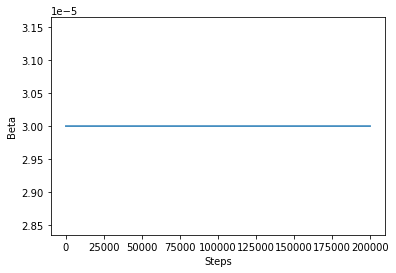

In [17]:
from lfp.train import BetaScheduler

TRAIN_STEPS = 200000
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=0.00003, 
                           beta_max=0.00003, 
                           max_steps=TRAIN_STEPS, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [18]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_grad_norm = np.float('inf')

In [19]:
run_name = args.run_name#"ALLB0.00003"
model_path = f'/content/drive/My Drive/Robotic Learning/saved_models/{run_name}/'

if args.resume:
  run_id = str(np.load(model_path+'hyper_params.npz')['run_id'])
  wandb.init(project="learning-from-play_v2", id='12621l2h',  resume="must")
  load_weights(model_path, actor, encoder, planner)
  load_optimizer_state(optimizer, model_path, strategy)
  print('Loaded model weights and optimiser state')
  t = wandb.run.step + valid_inc
else:
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


In [20]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
v_it = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset


In [ ]:
while t < TRAIN_STEPS:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = trainer.distributed_train_step(x, beta, prev_grad_norm)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if args.gcbc:
          total_val_loss = trainer.distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = trainer.distributed_test_step(valid_x, beta)

        # validation plotting
        metrics = {metric_name: log(metric) for metric_name, metric in trainer.metrics.items()}

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', metrics['train_loss']), 
                                ('Validation Loss', metrics['valid_loss']), 
                                ('Time (s)', round(time.time() - start_time, 1))])

        wandb.log(metrics, step=t)

        prev_grad_norm = metrics['global_grad_norm']
          
    if t % save_inc == 0:
        trainer.save_weights(model_path, wandb.run.id)
        if not args.gcbc:
          z_enc, z_plan = produce_cluster_fig(next(v_it), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size//4)
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          #latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	learning_from_play/
	wandb/

nothing added to commit but untracked files present (use "git add" to track)
